# This notebook, used with masif seed search, 

In [65]:
# Read the list of results.
with open(os.path.join(base_dir, 'list_out_peptides.txt')) as f:
    list_names = f.readlines()
    list_names = [x.rstrip() for x in list_names]


In [48]:
import numpy as np
import os
# Read all of the pairwise rmsd distances 
mydata_dict = {}
base_dir = 'analysis_fixed_size/'
data_dir = os.path.join(base_dir, 'out_data/')
for i in range(len(list_names)):
    fn = 'rmsd_{}.npy'.format(i)
    try:
        mydata_dict[int(i)] = np.load(os.path.join(data_dir,fn))
    except:
        continue


print(len(mydata_dict.keys()))

2378


## Remove any values that had an error. 

In [50]:
active_keys = list(mydata_dict.keys())
mydata = []
for key in active_keys:
    vals = np.array(mydata_dict[key])
    vals = vals[active_keys]
    mydata.append(vals)
mydata = np.asarray(mydata)
print(mydata.shape)

(2378, 2378)


In [66]:
# remove those results that had problems.
list_names = [x for ix, x in enumerate(list_names) if ix in active_keys]

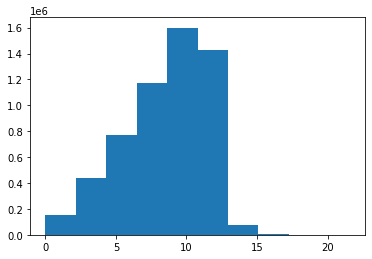

In [51]:
# Plot the rmds. 
mydata_flat = np.reshape(mydata, [-1])
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mydata_flat)
print()

In [52]:
# Run MDS on all pairwise distances, 

from sklearn.manifold import MDS
#runmds = MDS(n_components=2, metric=True, dissimilarity="precomputed", n_jobs=4, max_iter=1200, n_init=12)
runmds = MDS(n_components=2, metric=True, dissimilarity="precomputed")
mds_plot = runmds.fit_transform(mydata)

np.save('mds_plot.npy', mds_plot)


In [53]:
# Load the mds_plot, cluster into 6 clusters and make a dataframe.
mds_plot = np.load('mds_plot.npy')

# Rotate the mds_plot by 180 degrees
rot_matrix = [[-1, 0], [0,-1]]
mds_plot = np.dot(mds_plot, rot_matrix)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0).fit(mds_plot)

import pandas as pd
myplot = pd.DataFrame(mds_plot, columns=['x', 'y'])
myplot['cluster'] = kmeans.labels_

   Count  Cluster number
0    485               0
1    692               1
2    452               2
3    365               3
4    175               4
5    209               5


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "type" which is no longer supported as of 3.3 and will become an error two minor releases later
  if __name__ == '__main__':


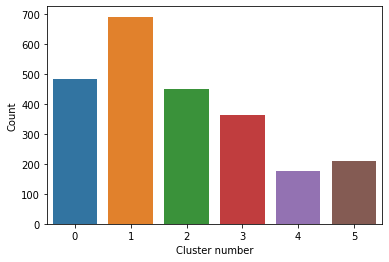

In [54]:
# plot the clusters
import seaborn as sns
histpy = np.histogram(kmeans.labels_, bins=[0,1,2,3,4,5,6])
histpy = np.array([histpy[0], [0,1,2,3,4,5]])

histdata = pd.DataFrame(histpy.T, columns=['Count', 'Cluster number'])
print(histdata)
sns.barplot(data=histdata,  y='Count', x='Cluster number')
plt.savefig('barplot.pdf', type='pdf')



tp_seed1 = list_names.index('3VGY000_D_60')
tp_seed2 = list_names.index('3VGY000_D_60')
tp_seed3 = list_names.index('3VGY000_D_60')
top_seeds = [mds_plot[tp_seed1], mds_plot[tp_seed2], mds_plot[tp_seed3]]
top_seeds = pd.DataFrame(top_seeds, columns=['x', 'y'])
weight = [1000]*len(top_seeds)
top_seeds['weight']= weight
top_seeds['mystyle'] = ['hexagon', 'triangle', 'star']

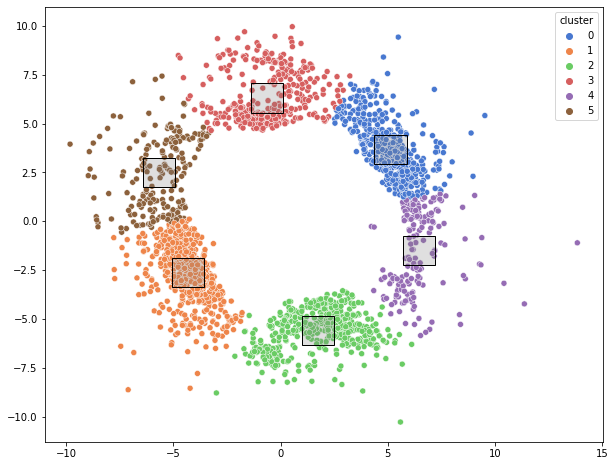

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib

palette=sns.color_palette('muted', n_colors=6)

myplot = pd.DataFrame(mds_plot, columns=['x', 'y'])
myplot['cluster'] = kmeans.labels_
%matplotlib inline
plt.figure(figsize=(10,8))
ax = sns.scatterplot(data=myplot, x="x", y='y', hue='cluster', palette=palette)
markers = {"star": "*", 'triangle': '>', 'hexagon': 'h'}
ax.set_xlabel('')
ax.set_ylabel('')
# Mark the patch of structures selected.
cc = kmeans.cluster_centers_
for k in range(len(cc)):
    mypatch1 = matplotlib.patches.Rectangle((cc[k][0]-0.75,cc[k][1]-0.75), width=1.5, height=1.5, color='gray', fill=True, alpha=0.25)
    mypatch2 = matplotlib.patches.Rectangle((cc[k][0]-0.75,cc[k][1]-0.75), width=1.5, height=1.5, color='black', fill=False)
    ax.add_patch(mypatch1)
    ax.add_patch(mypatch2)


plt.savefig('cluster_by_rmsd_legend.pdf', format='pdf')




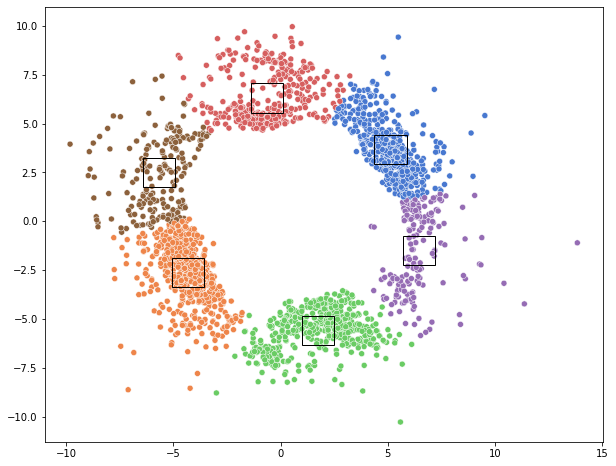

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib

palette=sns.color_palette('muted', n_colors=6)

myplot = pd.DataFrame(mds_plot, columns=['x', 'y'])
myplot['cluster'] = kmeans.labels_
%matplotlib inline
plt.figure(figsize=(10,8))
ax=sns.scatterplot(data=myplot, x="x", y='y', hue='cluster', palette=palette, legend=False)
markers = {"star": "*", 'triangle': '*', 'hexagon': '*'}
ax.set_xlabel('')
ax.set_ylabel('')
# Mark the patch of structures selected.
cc = kmeans.cluster_centers_
for k in range(len(cc)):
    mypatch2 = matplotlib.patches.Rectangle((cc[k][0]-0.75,cc[k][1]-0.75), width=1.5, height=1.5, color='black', fill=False)
    ax.add_patch(mypatch2)


plt.savefig('cluster_by_rmsd.pdf', format='pdf')


# Draw a logoplot on the selected helices positions of the cluster of choice. 

In [67]:
# Top cluster!
top_cluster = 1
# Find points near cluster center top_cluster
cp = kmeans.cluster_centers_[top_cluster]
idx_cluster_1_box = []
for i in range(len(mds_plot)):
    p = mds_plot[i]
    dist1 = np.sqrt(np.sum(np.square(p - cp)))
    if dist1 < 0.75:
        idx_cluster_1_box.append(i)


In [68]:
from Bio.PDB import * 
from IPython.core.debugger import set_trace
parser = PDBParser()

# One hot encoding of the residues.
data_one_hot = np.zeros((12, 20))
col_names = [Polypeptide.index_to_one(x) for x in range(20)]
pdb_dir = os.path.join(base_dir, 'out_pdb')
for i in range(len(list_names)):
    if i in idx_cluster_1_box:
        compstruct = parser.get_structure('comp', os.path.join(pdb_dir,list_names[i]+'_frag.pdb'))
        compres = Selection.unfold_entities(compstruct, 'R')
        do_compare=False
         
        rrix = 0        

        resn0 = Polypeptide.three_to_one(compres[rrix].get_resname())
        resn1 = Polypeptide.three_to_one(compres[rrix+1].get_resname())
        resn2 = Polypeptide.three_to_one(compres[rrix+2].get_resname())
        resn3 = Polypeptide.three_to_one(compres[rrix+3].get_resname())
        resn4 = Polypeptide.three_to_one(compres[rrix+4].get_resname())
        resn5 = Polypeptide.three_to_one(compres[rrix+5].get_resname())
        resn6 = Polypeptide.three_to_one(compres[rrix+6].get_resname())
        resn7 = Polypeptide.three_to_one(compres[rrix+7].get_resname())
        resn8 = Polypeptide.three_to_one(compres[rrix+8].get_resname())
        resn9 = Polypeptide.three_to_one(compres[rrix+9].get_resname())
        resn10 = Polypeptide.three_to_one(compres[rrix+10].get_resname())
        resn11 = Polypeptide.three_to_one(compres[rrix+11].get_resname())
        
        # Store the residue in the logo plot.
        data_one_hot[0][col_names.index(resn0)] += 1
        data_one_hot[1][col_names.index(resn1)] += 1
        data_one_hot[2][col_names.index(resn2)] += 1
        data_one_hot[3][col_names.index(resn3)] += 1
        data_one_hot[4][col_names.index(resn4)] += 1
        data_one_hot[5][col_names.index(resn5)] += 1
        data_one_hot[6][col_names.index(resn6)] += 1
        data_one_hot[7][col_names.index(resn7)] += 1
        data_one_hot[8][col_names.index(resn8)] += 1
        data_one_hot[9][col_names.index(resn9)] += 1
        data_one_hot[10][col_names.index(resn10)] += 1
        data_one_hot[11][col_names.index(resn11)] += 1    
                

In [69]:
data_one_hot_norm = data_one_hot/np.sum(data_one_hot[0])
df_aligns = pd.DataFrame(data_one_hot_norm, columns = col_names)

In [60]:
df_aligns

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,0.078947,0.006579,0.032895,0.072368,0.065789,0.026316,0.013158,0.046053,0.065789,0.131579,0.032895,0.039474,0.046053,0.052632,0.052632,0.065789,0.052632,0.059211,0.026316,0.032895
1,0.118421,0.026316,0.039474,0.059211,0.026316,0.065789,0.013158,0.078947,0.065789,0.118421,0.019737,0.032895,0.019737,0.059211,0.059211,0.072368,0.046053,0.039474,0.013158,0.026316
2,0.164474,0.013158,0.046053,0.046053,0.065789,0.039474,0.006579,0.046053,0.026316,0.118421,0.052632,0.026316,0.019737,0.026316,0.072368,0.065789,0.046053,0.052632,0.006579,0.059211
3,0.131579,0.013158,0.013158,0.039474,0.052632,0.059211,0.019737,0.065789,0.046053,0.157895,0.046053,0.006579,0.000000,0.026316,0.046053,0.052632,0.085526,0.078947,0.013158,0.046053
4,0.164474,0.013158,0.032895,0.032895,0.059211,0.138158,0.000000,0.072368,0.065789,0.131579,0.039474,0.006579,0.000000,0.039474,0.013158,0.052632,0.065789,0.059211,0.000000,0.013158
5,0.098684,0.019737,0.032895,0.078947,0.085526,0.032895,0.019737,0.111842,0.046053,0.125000,0.032895,0.032895,0.006579,0.039474,0.072368,0.019737,0.039474,0.059211,0.006579,0.039474
6,0.098684,0.013158,0.032895,0.032895,0.078947,0.032895,0.013158,0.118421,0.026316,0.157895,0.039474,0.039474,0.006579,0.046053,0.052632,0.059211,0.026316,0.059211,0.026316,0.039474
7,0.125000,0.013158,0.032895,0.032895,0.046053,0.052632,0.019737,0.131579,0.019737,0.223684,0.006579,0.019737,0.013158,0.019737,0.026316,0.019737,0.059211,0.085526,0.013158,0.039474
8,0.151316,0.032895,0.019737,0.039474,0.052632,0.026316,0.013158,0.098684,0.039474,0.177632,0.039474,0.026316,0.000000,0.052632,0.059211,0.032895,0.039474,0.052632,0.006579,0.039474
9,0.131579,0.000000,0.013158,0.111842,0.059211,0.039474,0.013158,0.078947,0.065789,0.190789,0.006579,0.006579,0.006579,0.046053,0.046053,0.026316,0.078947,0.032895,0.006579,0.039474


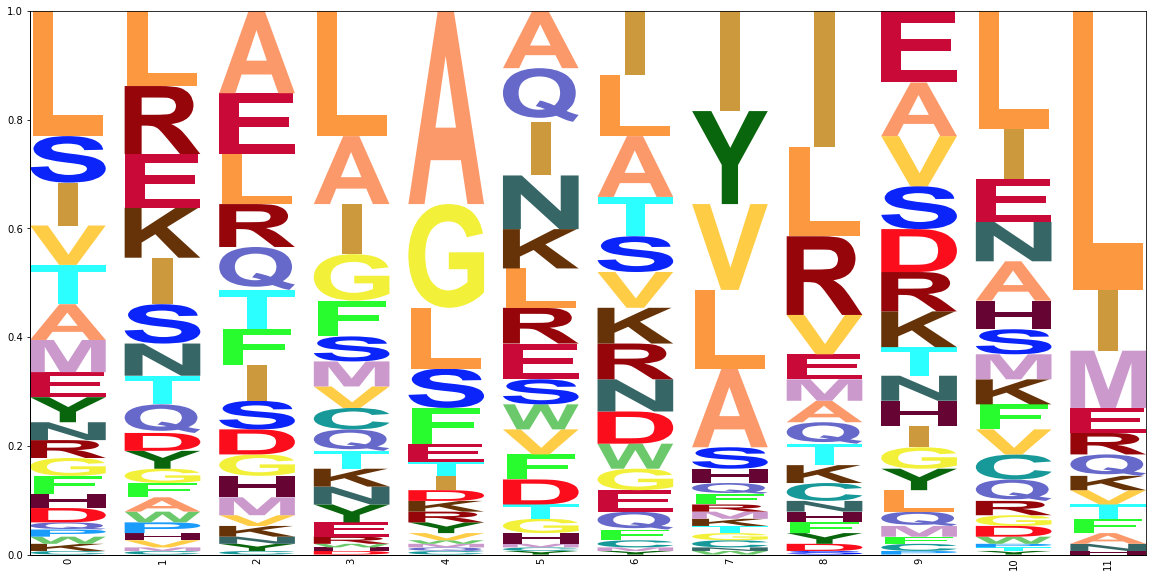

In [70]:
import logomaker

# standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# displays logos inline within the notebook;
# remove if using a python interpreter instead
%matplotlib inline



# logomaker import
import logomaker

fig, ax = plt.subplots(1,1,figsize=[20,10])

# create Logo object
crp_logo = logomaker.Logo(df_aligns, ax=ax, color_scheme='skylign_protein',
                          font_name='Arial', width=0.8)

# style using Logo methods
#crp_logo.style_spines(visible=False)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_xticks(rotation=90, fmt='%d', anchor=0)

# style using Axes methods
#crp_logo.ax.set_ylabel("Frequency")
crp_logo.ax.xaxis.set_ticks_position('none')
crp_logo.ax.xaxis.set_tick_params(pad=-1)

plt.savefig('logoplot.pdf')

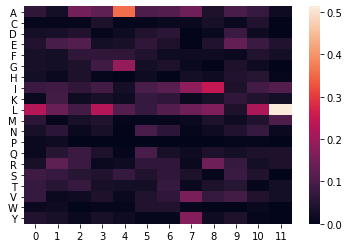

In [71]:
import matplotlib.pylab as plt 

ax = sns.heatmap(df_aligns.transpose())
ax.set_yticklabels(col_names, rotation=0)
plt.savefig('heatmap_seed.pdf')

# Print points in the cluster to visualize with pymol.

In [72]:
# Find points near cluster center #x
def find_points_near_cluster_plot_rmsd(cluster_ix):
    cp = kmeans.cluster_centers_[cluster_ix]
    count_elem = 0
    out_string = 'pymol'
    all_mds_dists = []
    all_cluster_ix = []
    for i in range(len(mds_plot)):
        p = mds_plot[i]
        dist = np.sqrt(np.sum(np.square(p - cp)))
        if dist < 0.75: 
            count_elem += 1
            out_string += " {}_frag.pdb".format(list_names[i])
            all_mds_dists.append(dist)
            all_cluster_ix.append(i)
    print(out_string)
    print('Num elems: {}'.format(count_elem))
    
    all_rmsds = []
    for i in all_cluster_ix:         
        all_rmsds.append(mydata[i, all_cluster_ix])
    all_rmsds = np.reshape(all_rmsds, [-1])
    
    sns.histplot(all_mds_dists)
    sns.histplot(all_rmsds)
    
    print('all_rmsds median: {}'.format(np.median(all_rmsds)))

In [73]:
ix1 = list_names.index('3HL0006_A_2')
ix2 = list_names.index('5V54000_A_35')
print(mydata[ix2,ix1])
print(ix1)
print(ix2)
mydata.shape

9.273174285888672
314
3


(2378, 2378)

In [44]:
len(list_names)

2461

pymol 6GPS002_A_40_frag.pdb 5AJI000_A_7_frag.pdb 1Q90002_D_78_frag.pdb 3R6H001_A_20_frag.pdb 3R6H001_A_17_frag.pdb 4HAY025_C_7_frag.pdb 6NDO005_A_8_frag.pdb 4B2Q001_T_43_frag.pdb 1XHK000_A_8_frag.pdb 5E76000_A_69_frag.pdb 4FBC000_A_8_frag.pdb 5OQP015_A_3_frag.pdb 3CWZ000_B_18_frag.pdb 4TUF000_A_20_frag.pdb 6S9M005_A_4_frag.pdb 4V25004_A_74_frag.pdb 5WL0002_A_38_frag.pdb 5WL0002_A_28_frag.pdb 3T4N002_A_19_frag.pdb 2JDQ003_A_19_frag.pdb 3VS9000_A_51_frag.pdb 3VS9000_A_41_frag.pdb 6RMA008_A_3_frag.pdb 6FLN000_A_3_frag.pdb 4MX2007_A_17_frag.pdb 5C2J004_A_42_frag.pdb 2GUW006_A_13_frag.pdb 2GUW006_A_31_frag.pdb 6IFZ008_A_22_frag.pdb 4CG5004_A_34_frag.pdb 4JP1000_A_0_frag.pdb 6BZC005_A_0_frag.pdb 3NWC001_A_6_frag.pdb 6MRP003_B_17_frag.pdb 6RZ6003_A_42_frag.pdb 5MXU002_A_24_frag.pdb 3TEN003_A_21_frag.pdb 6GV1006_A_14_frag.pdb 6EN4008_C_0_frag.pdb 1V4I004_A_15_frag.pdb 3SZZ001_A_11_frag.pdb 5ZJI000_J_3_frag.pdb 6J7X005_B_24_frag.pdb 2FSJ003_A_62_frag.pdb 1HE3001_A_23_frag.pdb 1YQF002_A_72_frag.

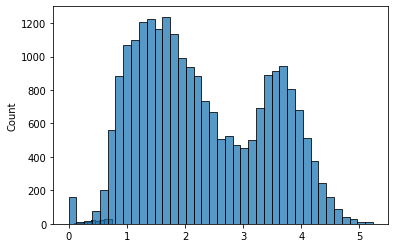

In [74]:
find_points_near_cluster_plot_rmsd(1)

pymol 3P5P011_A_10_frag.pdb 5AFF005_A_5_frag.pdb 1AHP009_A_7_frag.pdb 4EWG005_A_17_frag.pdb 5ZVS016_2_2_frag.pdb 6S7O001_C_22_frag.pdb 2E74002_B_41_frag.pdb 1PZT000_A_50_frag.pdb 5FVJ001_A_27_frag.pdb 1AH0001_A_25_frag.pdb 3EPS006_A_10_frag.pdb 2Y75000_A_8_frag.pdb 1Z1N005_X_22_frag.pdb 1MU2001_A_40_frag.pdb 4XR7005_L_29_frag.pdb 5M7Y001_A_7_frag.pdb
Num elems: 16
all_rmsds median: 4.4441001415252686


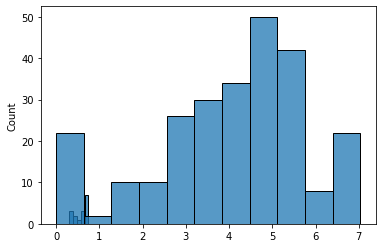

In [35]:
find_points_near_cluster_plot_rmsd(2)

pymol 1KW5001_A_24_frag.pdb 4F4C003_A_14_frag.pdb 3N14003_A_15_frag.pdb 3W9J021_A_83_frag.pdb 3W9J021_A_3_frag.pdb 3W9J021_A_61_frag.pdb 3W9J021_A_62_frag.pdb 4IGG001_A_196_frag.pdb 6QFK005_A_54_frag.pdb 3GPD000_R_11_frag.pdb 4UW2004_A_53_frag.pdb 5A1S000_A_88_frag.pdb 3W4T011_A_13_frag.pdb 4N4W002_A_61_frag.pdb 6J8E020_A_123_frag.pdb 2FNQ001_A_23_frag.pdb 5ZEA003_D_10_frag.pdb 3L5L003_A_15_frag.pdb 3IQ1002_A_51_frag.pdb 6HLO000_A_175_frag.pdb 4IAR007_A_32_frag.pdb 5XAT000_A_48_frag.pdb 6BAC003_A_53_frag.pdb 1MJE001_A_47_frag.pdb 5UR4000_A_12_frag.pdb 5OXN002_A_6_frag.pdb 5BZ3006_A_130_frag.pdb
Num elems: 27
all_rmsds median: 4.521072864532471


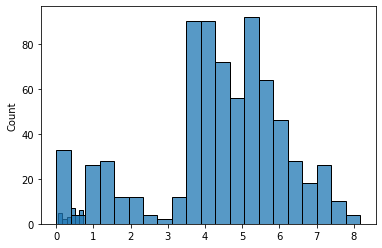

In [21]:
find_points_near_cluster_plot_rmsd(5)

pymol 1KW5001_A_24_frag.pdb 4F4C003_A_14_frag.pdb 3N14003_A_15_frag.pdb 3W9J021_A_83_frag.pdb 3W9J021_A_3_frag.pdb 3W9J021_A_61_frag.pdb 3W9J021_A_62_frag.pdb 4IGG001_A_196_frag.pdb 6QFK005_A_54_frag.pdb 3GPD000_R_11_frag.pdb 4UW2004_A_53_frag.pdb 5A1S000_A_88_frag.pdb 3W4T011_A_13_frag.pdb 4N4W002_A_61_frag.pdb 6J8E020_A_123_frag.pdb 2FNQ001_A_23_frag.pdb 5ZEA003_D_10_frag.pdb 3L5L003_A_15_frag.pdb 3IQ1002_A_51_frag.pdb 6HLO000_A_175_frag.pdb 4IAR007_A_32_frag.pdb 5XAT000_A_48_frag.pdb 6BAC003_A_53_frag.pdb 1MJE001_A_47_frag.pdb 5UR4000_A_12_frag.pdb 5OXN002_A_6_frag.pdb 5BZ3006_A_130_frag.pdb
Num elems: 27
all_rmsds median: 4.521072864532471


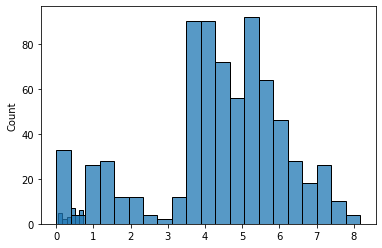

In [22]:
find_points_near_cluster_plot_rmsd(5)

In [91]:
from Bio.PDB import * 
parser = PDBParser()
# Plot length of fragments. 
all_lengths = []
for i in range(len(list_names)):
    compstruct = parser.get_structure('comp', 'out_pdb/'+list_names[i]+'_frag.pdb')
    compres = Selection.unfold_entities(compstruct, 'R')
    all_lengths.append(len(compres))

<AxesSubplot:ylabel='Count'>

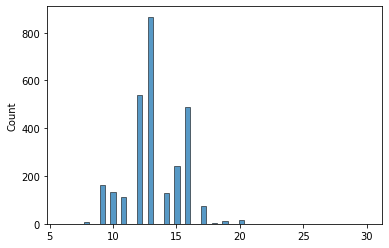

In [92]:
sns.histplot(all_lengths)

In [93]:
np.max(all_lengths)

30

In [94]:
np.median(all_lengths)

13.0